In [1]:
import splitfolders
import numpy as np
import seaborn
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [3]:
# Split folders into train and test
import splitfolders

input_folder = 'C:/Users/pc/Desktop/Projects/artifactRecognition/images/combined_images/'

splitfolders.ratio(input_folder, output="C:/Users/pc/Desktop/Projects/artifactRecognition/splitted_images",
    seed=42, ratio = (.8,.0,.2),
    group_prefix = None
)

In [2]:
# Image dataset path
train_dataset_path = 'C:/Users/pc/Desktop/Projects/artifactRecognition/splitted_images/train'
validation_dataset_path = 'C:/Users/pc/Desktop/Projects/artifactRecognition/splitted_images/test'

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 16

# Batch size 16 dene


In [4]:
# Loading datasets and apply augmentations

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                    target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 17449 images belonging to 12 classes.


In [5]:
# load the validation model

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical',
                                                              shuffle=True)

Found 4366 images belonging to 12 classes.


In [6]:
# getting the label mappings

labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label mappings for classes present in training and test datasets \n")

for key, value in labels.items():
    print(f"{key} : {value}")



Label mappings for classes present in training and test datasets 

0 : alexander sarcophagus
1 : david statue
2 : dead sea scrolls
3 : goddess tara statue
4 : mona lisa
5 : nefertiti bust
6 : nike of samothrace
7 : parthenon sculptures
8 : rosetta stone
9 : sutton hoo helmet
10 : terracotta army
11 : tutankhamun tomb


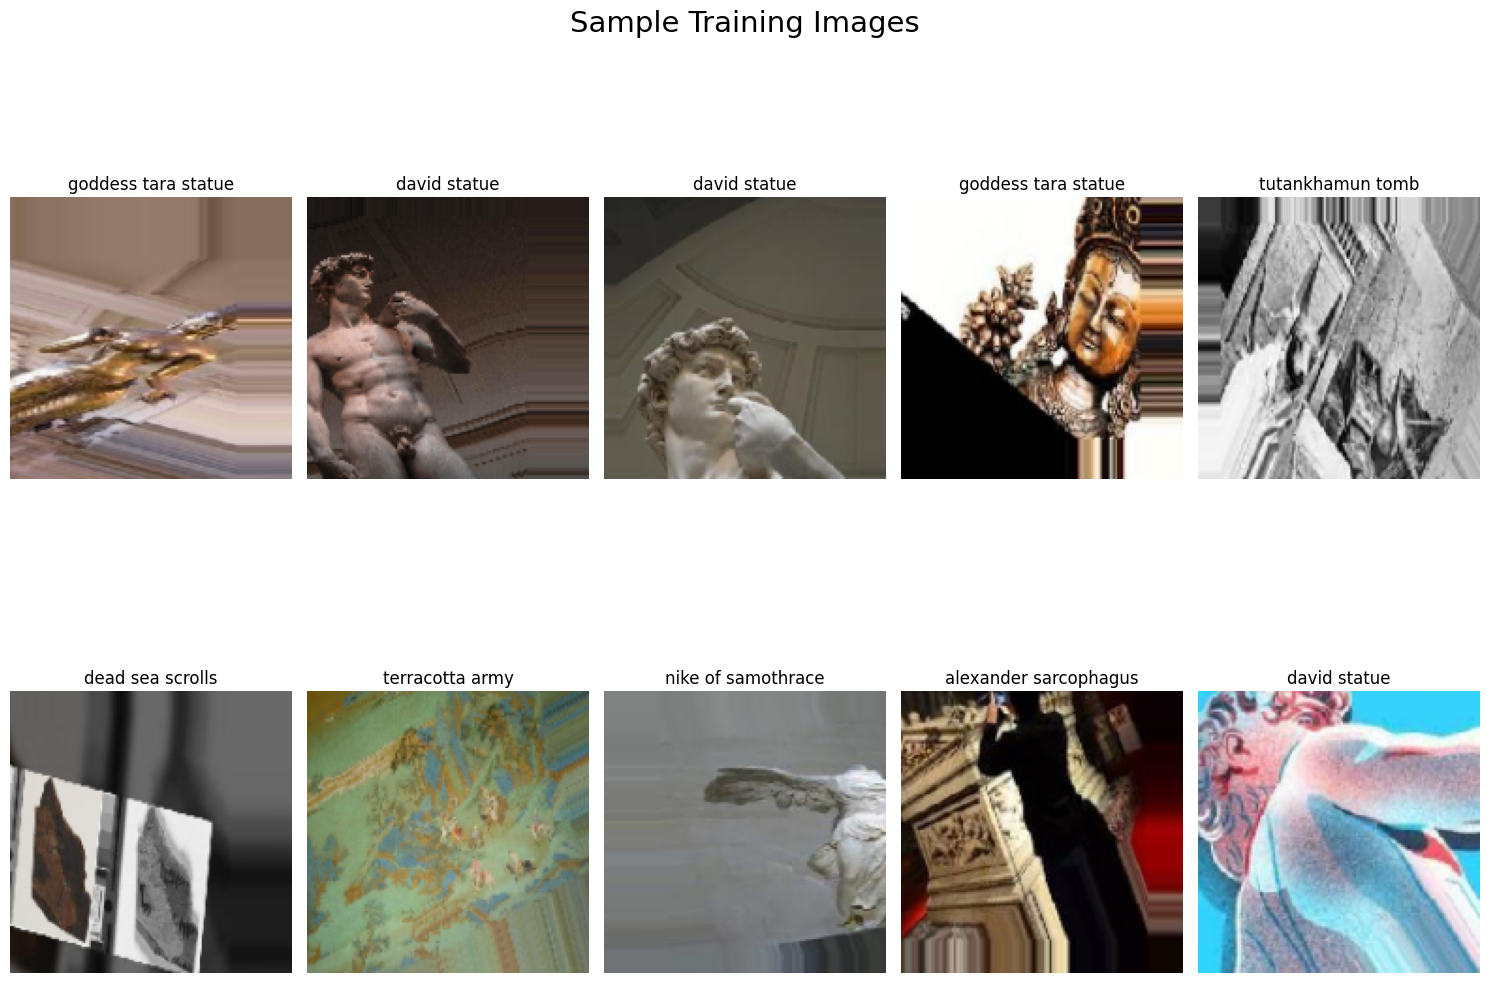

In [7]:
# Plotting Sample Training Images

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [7]:
# Create a CNN model

n_classes = 12

def create_model():
    
        model = Sequential()

        model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))),
        model.add(Activation('relu')),
        model.add(MaxPooling2D(pool_size=(2, 2))),
        model.add(BatchNormalization()),
        
        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005))),
        model.add(Activation('relu')),
        model.add(MaxPooling2D(pool_size=(2, 2))),
        model.add(BatchNormalization()),
        
        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005))),
        model.add(Activation('relu')),
        model.add(MaxPooling2D(pool_size=(2, 2))),
        model.add(BatchNormalization()),

        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005))),
        model.add(Activation('relu')),
        model.add(MaxPooling2D(pool_size=(2, 2))),
        model.add(BatchNormalization()),

        model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005))),
        model.add(Activation('relu')),
        model.add(MaxPooling2D(pool_size=(2, 2))),
        model.add(BatchNormalization()),


        model.add(Flatten()),
        
        model.add(Dense(units=256, activation='relu')),
        model.add(Dropout(0.5)),
        model.add(Dense(units=n_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    
        return model

In [8]:
cnn_model = create_model()

In [10]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 activation (Activation)     (None, 146, 146, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

In [9]:
# Defining Callbacks
# Reduce Learning Rate (Is used to reduce the learning rate when a metric has stopped improving.)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)


In [10]:
# Defining the optimizer
optimizer = Adam(learning_rate=0.001)

In [11]:
# Compile the model

cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
1091/1091 - 124s - loss: 2.1201 - accuracy: 0.3299 - val_loss: 1.7890 - val_accuracy: 0.4494 - lr: 0.0010 - 124s/epoch - 114ms/step
Epoch 2/50
1091/1091 - 103s - loss: 1.7358 - accuracy: 0.4411 - val_loss: 1.6730 - val_accuracy: 0.4828 - lr: 0.0010 - 103s/epoch - 95ms/step
Epoch 3/50
1091/1091 - 103s - loss: 1.5874 - accuracy: 0.4951 - val_loss: 2.1973 - val_accuracy: 0.3662 - lr: 0.0010 - 103s/epoch - 94ms/step
Epoch 4/50
1091/1091 - 100s - loss: 1.4898 - accuracy: 0.5295 - val_loss: 1.5761 - val_accuracy: 0.4993 - lr: 0.0010 - 100s/epoch - 92ms/step
Epoch 5/50
1091/1091 - 102s - loss: 1.4098 - accuracy: 0.5584 - val_loss: 1.3133 - val_accuracy: 0.5818 - lr: 0.0010 - 102s/epoch - 94ms/step
Epoch 6/50
1091/1091 - 103s - loss: 1.3285 - accuracy: 0.5873 - val_loss: 1.2464 - val_accuracy: 0.6024 - lr: 0.0010 - 103s/epoch - 94ms/step
Epoch 7/50
1091/1091 - 102s - loss: 1.2739 - accuracy: 0.6089 - val_loss: 1.2383 - val_accuracy: 0.6143 - lr: 0.0010 - 102s/epoch - 94ms/step
Epoch

In [18]:
cnn_model.save('best_model.h5')

In [16]:
from tensorflow.keras.models import load_model

In [17]:
loaded_model = load_model('best_model.h5')

In [23]:
# Testing the model on Test set

test_dataset = 'C:/Users//pc/Desktop/Projects/artifactRecognition/testimages/'

In [24]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 116 images belonging to 12 classes.


In [25]:
def predict_and_visualize(model, test_generator, class_names, n_images=12):
    # Get predictions on test set
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_class_labels = np.argmax(predictions, axis=1)
    true_class_labels = test_generator.classes
    
    # Create figure with subplots for images and predicted labels
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(30, 15))
    
    # Select random images and plot them with their predicted and true labels
    selected_indices = []
    for i in range(len(class_names)):
        class_indices = np.where(true_class_labels == i)[0]
        if len(class_indices) > 0:
            idx = np.random.choice(class_indices)
            selected_indices.append(idx)
    
    for i, idx in enumerate(selected_indices[:n_images]):
        # Get image and its predicted and true label
        image_path = os.path.join(test_generator.filepaths[idx])
        image = plt.imread(image_path)
        predicted_class_label = class_names[predicted_class_labels[idx]]
        true_class_label = class_names[true_class_labels[idx]]
        
        # Plot image and predicted and true labels
        axs[i//6, i%6].imshow(image)
        axs[i//6, i%6].axis('off')
        axs[i//6, i%6].set_title(f'Predicted: {predicted_class_label}\n\nTrue: {true_class_label}')
        

    
    plt.show()



8/8 [==============================] - 1s 82ms/step


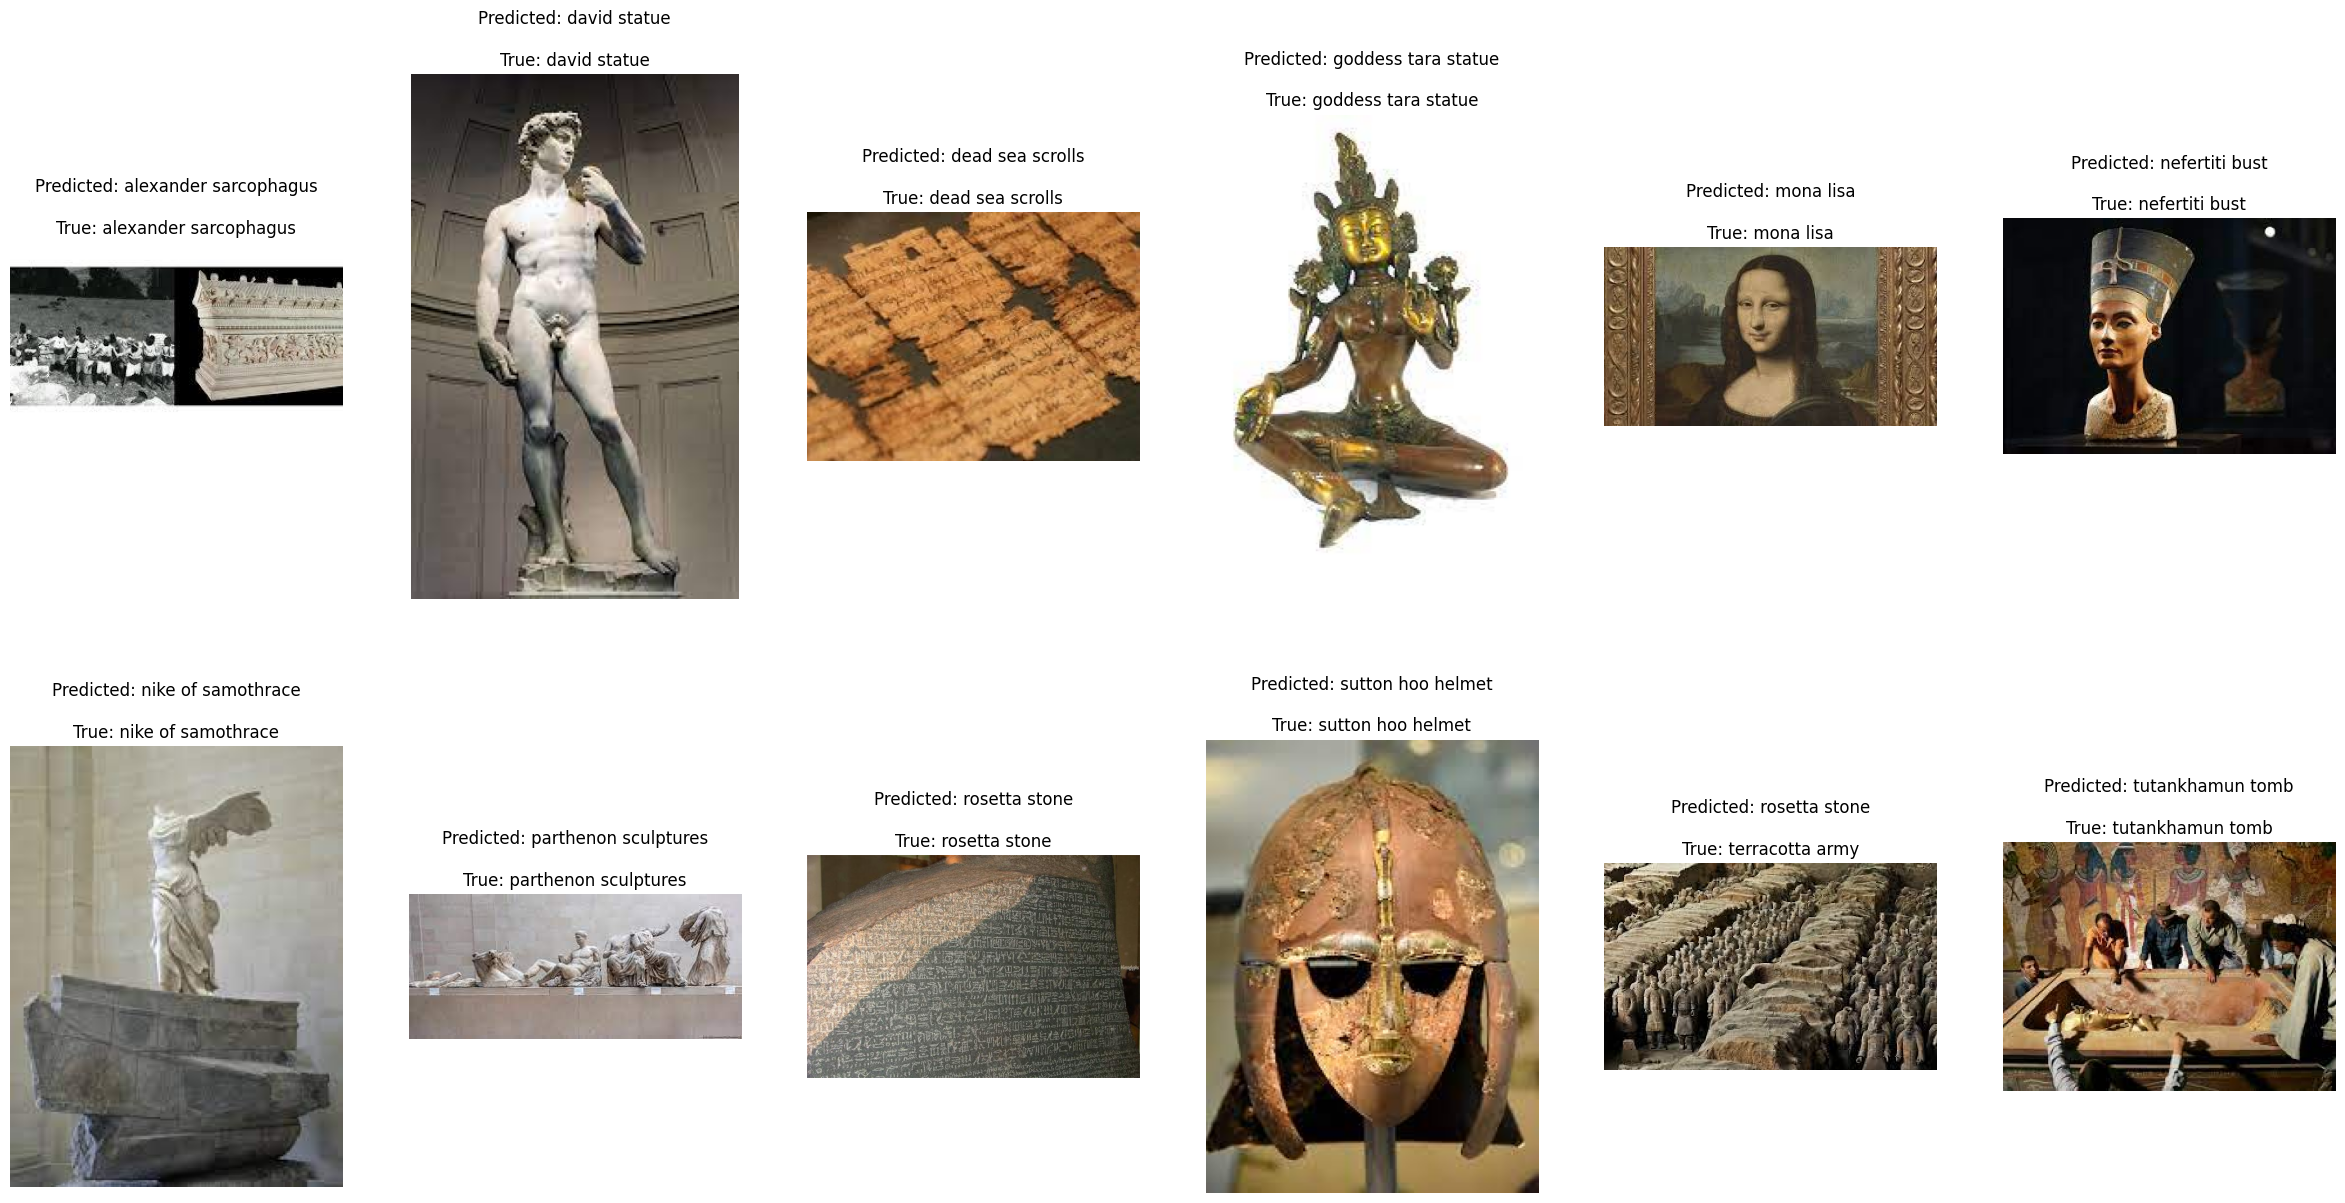

In [26]:
predict_and_visualize(loaded_model, test_generator, labels)

In [92]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

273/273 [==============================] - 9s 34ms/step - loss: 0.5183 - accuracy: 0.8798
